# Analyse de l'influence des distributions des temps inter-véhiculaires sur un axe routier

Paramètres de simulation:
- 1 voie
- longueur de la voie : 15900 m
- présence d'outils de contrôle de la circulation : non
- paramètres de distribution 
    <br/> dn -> N(8.33, 1) [m]
    <br/> longueur -> N(7, 1) [m]
    <br/> vitesse -> N(14, 3) [m.s^-1]
    <br/> t -> N(2, 0.5) [s]
- durée de la simulation : 500 s = 5000 1/10s   
- seed pour reproductibilité : 45

import des librairies:

In [4]:
import numpy as np  
import network, simulation 
import makesimulation 
import matplotlib.pyplot as plt
import analysis
import statistics
import seaborn


Récupération des fichiers initiaux

In [5]:
world = network.World.load('simple-net.yml')  
sim = simulation.Simulation.load('config.yml')

tracé des trajectoires selon les différentes valeurs des distribution pour les headway

- headways -> Exp(1.8, 1)
</br> On décalle la distribution à 1s % les temps inter-véhiculaires produits ne seront pas inférieurs à cette valeur

In [ ]:
# liste des headways a essayer:
#headways = [x for x in np.arange(.5,2.1,.1)]
headways = [.5]#, 1]#, 1.5]
# colors = ['y']#, 'b']#, 'r']
hList = []
cList = []
plt.figure(num=0)
for h in headways:
    # modification des paramètres dans simple-net.yml
    # au cas ou
    world = network.World.load('inputData/simple-net.yml')  
    world.userInputs[0].distributions['headway'].scale = h

    # running the simulation
    world = makesimulation.run(world, sim)
    print('trying headway = {}'.format(1+h))

    #get number of interactions
    interactionDuration = world.getInteractionsDuration(dmin=25, inLine=True)
    for pair in interactionDuration:
        analysis.getDistanceValuesBetweenUsers(world, world.getUserByNum(pair[0]), world.getUserByNum(pair[1]), 0, True)
plt.show()
    
    

trying headway = 1.2
133 140
trying headway = 1.4
127 142
trying headway = 1.6
113 151
trying headway = 1.8
123 152
trying headway = 2
131 141
trying headway = 2.2
121 155


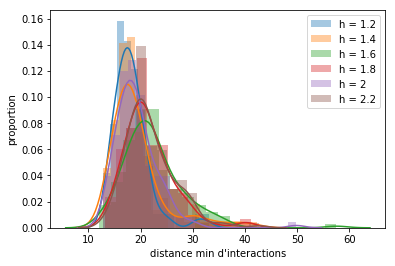

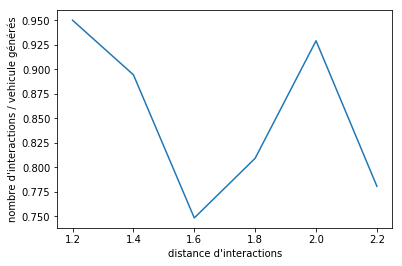

In [8]:
# liste des headways a essayer:
headways = [1.2, 1.4, 1.6, 1.8, 2, 2.2]#, 2.4, 2.6, 2.8]
cList = []
plt.figure(num=0)
for h in headways:
    # modification des paramètres dans simple-net.yml
    # au cas ou
    world = network.World.load('simple-net.yml')  
    world.userInputs[0].distributions['headway'].scale = h-1

    # running the simulation
    world = makesimulation.run(world, sim)
    print('trying headway = {}'.format(h))
    
#     get number of interactions
    interactionDuration = analysis.getInteractionsDuration(world, dmin=25, inLine=True)
    c = 0 # nombre de fois ou la distance entre les usagers est tombee en dessous de 25m
#     interactionLength = []
    for pair in interactionDuration:
        if interactionDuration[pair][0] !=0:
            c += interactionDuration[pair][0]
#             interactionLength.append(interactionDuration[pair][1:])
    print(c, len(world.getNotNoneVehiclesInWorld()[0]))
    cList.append(c/len(world.getNotNoneVehiclesInWorld()[0]))
    
    d = analysis.getMinDistanceBetweenEachPairCF(world)
    ax = seaborn.distplot(d, rug=False, hist=True, label='h = '+str(h), norm_hist=True)
    plt.xlabel("distance min d'interactions")
    plt.ylabel("proportion")
    ax.legend()

plt.figure(num=1)
plt.xlabel("distance d'interactions")
plt.ylabel("nombre d'interactions / vehicule générés")
plt.plot(headways, cList)
plt.show()
    
    

trying headway = 0.5
115 248925
trying headway = 0.6
113 240153
trying headway = 0.7
124 302476
trying headway = 0.7999999999999999
123 289432
trying headway = 0.8999999999999999
121 280636
trying headway = 0.9999999999999999
131 307239
trying headway = 1.0999999999999999
105 217033
trying headway = 1.1999999999999997
121 281906
trying headway = 1.2999999999999998
126 283420
trying headway = 1.4
103 204036
trying headway = 1.4999999999999998
123 272086
trying headway = 1.5999999999999996
112 246593
trying headway = 1.6999999999999997
121 262874
trying headway = 1.7999999999999998
110 238880
trying headway = 1.8999999999999997
120 255540
trying headway = 1.9999999999999996
95 173925


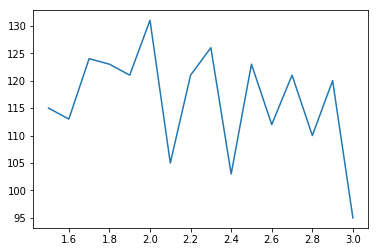

In [5]:
sim.seed = 45

# liste des headways a essayer:
headways = [x for x in np.arange(.5,2.1,.1)]
# headways = [.8, .9, ]
hList = []
cList = []
for h in headways:
    # modification des paramètres dans simple-net.yml
    # au cas ou
    world = network.World.load('simple-net.yml')  
    
    world.userInputs[0].distributions['headway'].scale = h

    # running the simulation
    world = makesimulation.run(world, sim)
    print('trying headway = {}'.format(h))
    
    #get number of interactions
    interactionDuration = world.getInteractionsDuration(dmin=25, inLine=True)
    c = 0 # nombre d'interaction
    s = 0 # duree moyenne des interactions
    interactionLength = []
    for pair in interactionDuration:
        if interactionDuration[pair][0] !=0:
            c += interactionDuration[pair][0]
            s += sum(interactionDuration[pair][1:])
            interactionLength.append(interactionDuration[pair][1:])
    print(c, s)
    hList.append(1+h)
    cList.append(c)
plt.plot(hList, cList)
plt.show()
    
    

<br/> Nombre de véhicules simulés/Nombre de véhicules générés : 

print(str(len(world.getNotNoneVehiclesInWorld()[0])) + '/'+ str(len(world.users)))

Distribution des headways observés

h = analysis.getHeadwayValues(world)
plt.xlabel('headway values')
plt.ylabel('Proportions')
plt.hist(h[0], density=True, bins = 25)

# print(statistics.mean(h[0]))
# print(statistics.mean(world.userInputs[0].headways))

Distribution des min des distances inter-véhiculaires, pour une coexistence d'une durée minimale de 2 min = 1200 1/10s

d = analysis.getMinDistanceBetweenEachPairCF(world, 1200)

plt.hist(d, bins=22, density=False)# 'min distance between users', 'proportions')

Nombre d'interactions et leur durée observées à une distance < 25 m

In [36]:
interactionDuration = world.getInteractionsDuration(dmin=25, inLine=True)

c = 0 # nombre d'interaction
s = 0 # duree moyenne des interactions
interactionLength = []
for pair in interactionDuration:
    if interactionDuration[pair][0] !=0:
        c += interDuration[pair][0]
        s += sum(interactionDuration[pair][1:])
        interactionLength.append(interactionDuration[pair][1:])
print(c, s)

Durée moyenne des interactions

if c != 0:
    print(s/c)

distribution de la durée des interactions (ayant lieu a une distance < 25 m)
</br>**a voir**

plt.hist(interactionLength, bins=3, density=False)

Tracé des courbes de TTC

minTTCValues = analysis.getTTCValuesForEachPairOfVehicles(world, sim, plot=True)[1]

Distribution des TTC min

plt.hist(minTTCValues, bins=30, density=True)
minTTCValues

- headways -> Exp(2, 1)